In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
markers = list(Line2D.markers.keys())  # ['.', '+', 'x', 's', 'P', 'D']

import pandas as pd
import seaborn as sns

import torch
import clip

from ipywidgets import interact, widgets
from tqdm.notebook import tqdm

from PIL import Image
from skimage.io import imread, imread_collection
from skimage.util import img_as_ubyte
from skimage.transform import AffineTransform, warp

In [2]:
FOLDER = "global_adversarial.ignore"

BASELINE_IMAGE = 'start.ignore.png'  # '../data/white.png'

STATIC_JIBBERISH = 'uiih rfvfgbblae ghwyrfyegf'
RANDOM_JIBBERISH_LENGTH = 20

NEGATIVE_PREFIX = 'Not'
STARTING_TEXT_PROMPTS = ['A random image', 'A white canvas']  # 'Geometric shapes on a white background'

ALPHA = np.around(np.linspace(0, 0.5, 11), 2)
BETA = np.around(np.linspace(0, 0.5, 11), 2)

TEMPERATURE = [1, 2, 3, 5, 7, 8, 10, 20, 30, 50]

# CATEGORIES = ["house", "bird", "fish", "tree", "cat", "dog", "horse", "rabbit", "goat", "shirt", "chair"]  # , "boat"]
CATEGORIES = ["house", "bird", "fish", "tree", "cat", "dog", "horse", "rabbit", "goat", "shirt", "chair", "boat", "swan", "camel", "bear", "duck", "teapot", "hammer", "boot", "key", "gun", "apple", "car", "guitar", "flower", "heart"]

SEED = 42

DEVICE = 'cpu'

In [3]:
PREFIXES = [
    ["", "A", "An abstract"],
    ["", "A tangram representation of", "A tangram puzzle of", "A geometric depiction of", "A tangram-inspired", "A tangram-like"]
]
SUFFIXES = [
    ["", "made of tangrams", "formed from tangrams", "consisting of tangrams", "assembled from tangrams", "created with tangrams"],
    ["", "pattern", "configuration", "shape", "arrangement", "composition"]
]
NEGATIVE_PREFIXES = [[f"{NEGATIVE_PREFIX} {prefix[0].lower()}{prefix[1:]}" if prefix else NEGATIVE_PREFIX for prefix in prefix_list] for prefix_list in PREFIXES]

---

- Read images from a FOLDER of adversarial images, in a list
- For each of the image, run inference for all the ablation cases
    - for every prompt combination:
        - for alpha in [0:0.5:0.05], calculate embeddings
            - (1 - alpha) * (prompt) - (alpha) * (negative)
            - (1 - alpha) * (prompt + jibberish) - (alpha) * (negative + jibberish)
        
    - for image in images {original, skewed, hatched}
        - for beta in [0:0.1:0.01]
            - (1 - beta) * (image) - (beta) * (random)

    - calculate distances (dot products) between each pair

    - for temperature in [0:100:10]
        - calculate probabilities

    - Calculate the performance metrics 

In [4]:
import string
import random
random.seed(SEED)
get_random_string = lambda length: random.choice(string.ascii_lowercase) + ''.join(random.choice(string.ascii_lowercase + ' ' * 2) for _ in range(length - 1))

In [5]:
torch.set_grad_enabled(False)
model, preprocess = clip.load("ViT-L/14", device=DEVICE)
model.eval();

In [13]:
# with open('text_embeddings.ignore.pt', 'rb') as f:
#     text_embeddings = torch.load(f, map_location=DEVICE)

In [8]:
positive_text_features_list = []
negative_text_features_list = []
combination_list = []
for ps in (post_suffixes := ['', STATIC_JIBBERISH, None, None, None]):
    for prefix_list, suffix_list, neg_prefix_list in zip(PREFIXES, SUFFIXES, NEGATIVE_PREFIXES):
        for prefix, neg_prefix in zip(prefix_list, neg_prefix_list):
            for suffix in suffix_list:
                post_suffix = ps if ps is not None else get_random_string(RANDOM_JIBBERISH_LENGTH)
                combination_list.append((prefix, f'{neg_prefix}...', suffix, post_suffix))

                positive_labels = [f'{prefix} {label} {suffix} {post_suffix}' for label in CATEGORIES]
                positive_text_features = model.encode_text(clip.tokenize(positive_labels).to(DEVICE))
                positive_text_features /= positive_text_features.norm(dim=-1, keepdim=True)
                positive_text_features_list.append(positive_text_features)

                negative_labels = [f'{neg_prefix} {label} {suffix} {post_suffix}' for label in CATEGORIES]
                negative_text_features = model.encode_text(clip.tokenize(negative_labels).to(DEVICE))
                negative_text_features /= negative_text_features.norm(dim=-1, keepdim=True)
                negative_text_features_list.append(negative_text_features)

positive_text_embeddings = torch.stack(positive_text_features_list)
negative_text_embeddings = torch.stack(negative_text_features_list)

starting_text_embeddings = []
for starting_text_prompt in STARTING_TEXT_PROMPTS:
    starting_text_features = model.encode_text(clip.tokenize(starting_text_prompt).to(DEVICE))
    starting_text_features /= starting_text_features.norm(dim=-1, keepdim=True)
    starting_text_embeddings.append(starting_text_features)

In [9]:
combination_list += [(combination[0], starting_text_prompt) + combination[2:] for starting_text_prompt in STARTING_TEXT_PROMPTS for combination in combination_list]

text_embeddings = {}
for alpha_text in ALPHA:
    text_embeddings[alpha_text] = torch.vstack((
            (1 - alpha_text) * positive_text_embeddings - alpha_text * negative_text_embeddings,
            *[(1 - alpha_text) * positive_text_embeddings - alpha_text * starting_text_embedding for starting_text_embedding in starting_text_embeddings],
    ))
    text_embeddings[alpha_text] /= text_embeddings[alpha_text].norm(dim=-1, keepdim=True)

In [10]:
# with open('text_embeddings.ignore.pt', 'wb') as f:
#     torch.save(text_embeddings, f)

In [10]:
images = {
    'normal': [*(pictures := imread_collection(f"./{FOLDER}/*/*.png"))],  # 'ambiguous', 'bad', good'
    'sheared': [img_as_ubyte(warp(picture, AffineTransform(shear=(0.15, 0.15)), cval=1.)) for picture in pictures]
}
a_slice = slice(0, len(imread_collection(f"./{FOLDER}/ambiguous/*.png")))
b_slice = slice(a_slice.stop, a_slice.stop + len(imread_collection(f"./{FOLDER}/bad/*.png")))
c_slice = slice(a_slice.start, b_slice.stop)
g_slice = slice(b_slice.stop, b_slice.stop + len(imread_collection(f"./{FOLDER}/good/*.png")))  # -1

In [11]:
positive_image_embeddings = dict.fromkeys(images, None)
for image_type in images:
    positive_image_embeddings[image_type] = model.encode_image(torch.cat([preprocess(Image.fromarray(image)).to(DEVICE) for image in images[image_type]]).view(-1, 3, 224, 224))
    positive_image_embeddings[image_type] /= positive_image_embeddings[image_type].norm(dim=-1, keepdim=True)

In [12]:
baseline_image_embedding = dict(zip(images.keys(), [
    model.encode_image(preprocess(Image.open(BASELINE_IMAGE)).to(DEVICE).unsqueeze(0)).squeeze(0),
    model.encode_image(preprocess(Image.fromarray(img_as_ubyte(warp(imread(BASELINE_IMAGE), AffineTransform(shear=(0.15, 0.15)), cval=1.)))).to(DEVICE).unsqueeze(0)).squeeze(0)
]))
for image_type in images:
    baseline_image_embedding[image_type] /= baseline_image_embedding[image_type].norm(dim=-1, keepdim=True)

In [13]:
image_embeddings = dict.fromkeys(images, None)
for image_type in images:
    image_embeddings[image_type] = {}
    for beta_image in BETA:
        image_embeddings[image_type][beta_image] = (1 - beta_image) * positive_image_embeddings[image_type] - beta_image * baseline_image_embedding[image_type]
        image_embeddings[image_type][beta_image] /= image_embeddings[image_type][beta_image].norm(dim=-1, keepdim=True)

In [14]:
distances = dict.fromkeys(images, None)
for image_type in images:
    distances[image_type] = {}
    for alpha in ALPHA:
        for beta in BETA:
            distances[image_type][alpha, beta] = model.logit_scale.exp() * text_embeddings[alpha] @ image_embeddings[image_type][beta].T

NameError: name 'text_embeddings' is not defined

In [ ]:
max_entropy = np.log(len(CATEGORIES))

results = dict.fromkeys(images, None)
entropies = dict.fromkeys(images, None)
for image_type in images:
    results[image_type] = {}
    entropies[image_type] = {}
    for temperature in TEMPERATURE:
        for alpha in ALPHA:
            for beta in BETA:
                results[image_type][temperature, alpha, beta] = (distances[image_type][alpha, beta] / temperature).softmax(dim=1)
                entropies[image_type][temperature, alpha, beta] = -(results[image_type][temperature, alpha, beta] * torch.log(results[image_type][temperature, alpha, beta])).sum(axis=1)

In [ ]:
metrics = dict.fromkeys(images, None)
for image_type in images:
    metrics[image_type] = {}
    for temperature in TEMPERATURE:
        for alpha_text in ALPHA:
            for beta_image in BETA:
                metrics[image_type][(temperature, alpha_text, beta_image)] = torch.vstack([entropies[image_type][temperature, alpha_text, beta_image][:, s].mean(axis=1) for s in (g_slice, b_slice)]).cpu().numpy()

In [ ]:
%matplotlib inline
plt.figure(figsize=(15, 10))
def plot(alpha_text, beta_image, temperature, jibberish, negative_prompt_style, image_type):
    jibberish = ['None', f'Same ({STATIC_JIBBERISH})', *[f'Random #{i}' for i in range(1, len(post_suffixes) - 1)]].index(jibberish)
    negative_prompt_style = ([f'{NEGATIVE_PREFIX}...'] + STARTING_TEXT_PROMPTS).index(negative_prompt_style)
    for temperature in TEMPERATURE if temperature == 0 else [temperature]:
        # for metric_jibberish, m in zip(np.split(metrics[image_type][(temperature, alpha_text, beta_image)], (len(STARTING_TEXT_PROMPTS) + 1) * len(post_suffixes), axis=1), markers[(len(STARTING_TEXT_PROMPTS) + 1) * len(post_suffixes)]):
        #     plt.scatter(*metric_jibberish, s=10, marker=m, label=temperature)
        plt.scatter(*np.split(metrics[image_type][(temperature, alpha_text, beta_image)], (len(STARTING_TEXT_PROMPTS) + 1) * len(post_suffixes), axis=1)[len(post_suffixes) * negative_prompt_style + jibberish],
                    s=10, marker=markers[len(post_suffixes) * negative_prompt_style + jibberish], label=temperature)
    plt.xlim(0, max_entropy)
    plt.ylim(0, max_entropy)
    plt.xlabel('Entropy of the proper image')
    plt.ylabel('Mean Entropy of the other images')
    # plt.legend(title='Temperature')

interact(plot,
         alpha_text=widgets.SelectionSlider(options=ALPHA),
         beta_image=widgets.SelectionSlider(options=BETA),
         temperature=widgets.SelectionSlider(options=[0] + TEMPERATURE),
         jibberish=widgets.RadioButtons(options=['None', f'Same ({STATIC_JIBBERISH})', *[f'Random #{i}' for i in range(1, len(post_suffixes) - 1)]]),
         negative_prompt_style=widgets.RadioButtons(options=[f'{NEGATIVE_PREFIX}...', *STARTING_TEXT_PROMPTS]),
         image_type=widgets.RadioButtons(options=images.keys()),
);

<Figure size 1500x1000 with 0 Axes>

interactive(children=(SelectionSlider(description='alpha_text', options=(0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,…

In [ ]:
win_counts_per_combination = dict.fromkeys(combination_list, 0)
valid_counts_per_combination = dict.fromkeys(combination_list, 0)
sum_performances_per_combination = dict.fromkeys(combination_list, 0)
sum_correct_image_entropies_per_combination = dict.fromkeys(combination_list, 0)
sum_incorrect_image_entropies_per_combination = dict.fromkeys(combination_list, 0)
best_performance_per_combination = dict.fromkeys(combination_list, 0)
best_hyperparams_per_combination = dict.fromkeys(combination_list, (0, 0, 0))
for temperature in TEMPERATURE:
    for alpha_text in ALPHA:
        for beta_image in BETA:
            single_metric = np.diff(metrics['normal'][temperature, alpha_text, beta_image], axis=0).squeeze()

            winning_combination = combination_list[np.argmax(single_metric)]
            win_counts_per_combination[winning_combination] += 1

            for i, (performance, combination) in enumerate(zip(single_metric, combination_list)):
                if not np.isnan(performance):
                    valid_counts_per_combination[combination] += 1
                    sum_performances_per_combination[combination] += performance
                    sum_correct_image_entropies_per_combination[combination] += metrics['normal'][temperature, alpha_text, beta_image][0, i]
                    sum_incorrect_image_entropies_per_combination[combination] += metrics['normal'][temperature, alpha_text, beta_image][1, i]
                    if performance > best_performance_per_combination[combination]:
                        best_performance_per_combination[combination] = performance
                        best_hyperparams_per_combination[combination] = (temperature, alpha_text, beta_image)

counts_per_combination = {combination:combination_list.count(combination) for combination in combination_list}
for combination, count in valid_counts_per_combination.items():
    win_counts_per_combination[combination] *= 100 / count  # * len(metrics['normal'])
    sum_performances_per_combination[combination] /= count  # * len(metrics['normal'])
    sum_correct_image_entropies_per_combination[combination] /= count  # * len(metrics['normal'])
    sum_incorrect_image_entropies_per_combination[combination] /= count  # * len(metrics['normal'])

In [ ]:
best_combination = max(best_performance_per_combination, key=best_performance_per_combination.get)
best_hyperparams = best_hyperparams_per_combination[best_combination]
(best_combination, best_hyperparams)

(('', 'Not...', 'formed from tangrams', 'uiih rfvfgbblae ghwyrfyegf'),
 (1, 0.5, 0.4))

In [ ]:
max(sum_performances_per_combination, key=sum_performances_per_combination.get)

('', 'A random image', 'pattern', 'uecpziktwmuc k v rmk')

In [ ]:
master_dataframe = pd.concat(
    [
        pd.DataFrame(counts_per_combination.keys(), columns=["Prefix", "Negative Prefix", "Suffix", "Post Suffix"]),
        pd.DataFrame(
            {
                "Win Counts": list(win_counts_per_combination.values()),
                "Sum Performances": list(sum_performances_per_combination.values()),
                "Sum Correct Image Entropies": list(sum_correct_image_entropies_per_combination.values()),
                "Sum Incorrect Image Entropies": list(sum_incorrect_image_entropies_per_combination.values()),
                "Best Performance": list(best_performance_per_combination.values()),
            }
        ),
        pd.DataFrame(best_hyperparams_per_combination.values(), columns=["Temperature", "Alpha (Text)", "Beta (Image)"]),
    ],
    axis=1,
)

In [ ]:
master_dataframe

,Prefix,Negative Prefix,Suffix,Post Suffix,Win Counts,Sum Performances,Sum Correct Image Entropies,Sum Incorrect Image Entropies,Best Performance,Temperature,Alpha (Text),Beta (Image)
0,,Not...,,,0.0,0.033279,2.411287,2.444565,0.258401,3,0.45,0.5
1,,Not...,made of tangrams,,0.0,0.004407,2.498598,2.503005,0.250163,1,0.50,0.5
2,,Not...,formed from tangrams,,0.0,-0.007129,2.470941,2.463813,0.525980,1,0.50,0.4
3,,Not...,consisting of tangrams,,0.0,0.003771,2.487828,2.491599,0.351727,1,0.45,0.3
4,,Not...,assembled from tangrams,,0.0,-0.031317,2.480963,2.449646,0.383067,1,0.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
799,A tangram-like,A white canvas,pattern,xpgg rirwiedtxshhbvq,0.0,-0.001187,2.487602,2.486414,0.197319,2,0.00,0.0
800,A tangram-like,A white canvas,configuration,huhbdnkwpdvyearfnupp,0.0,0.020027,2.379639,2.399666,0.308171,2,0.00,0.0
801,A tangram-like,A white canvas,shape,ugyjkjubycushrxx bfn,0.0,-0.020310,2.503232,2.482923,0.133911,2,0.00,0.0
802,A tangram-like,A white canvas,arrangement,fb mzpfx jbajstdkjou,0.0,0.007511,2.367835,2.375345,0.246316,2,0.00,0.0


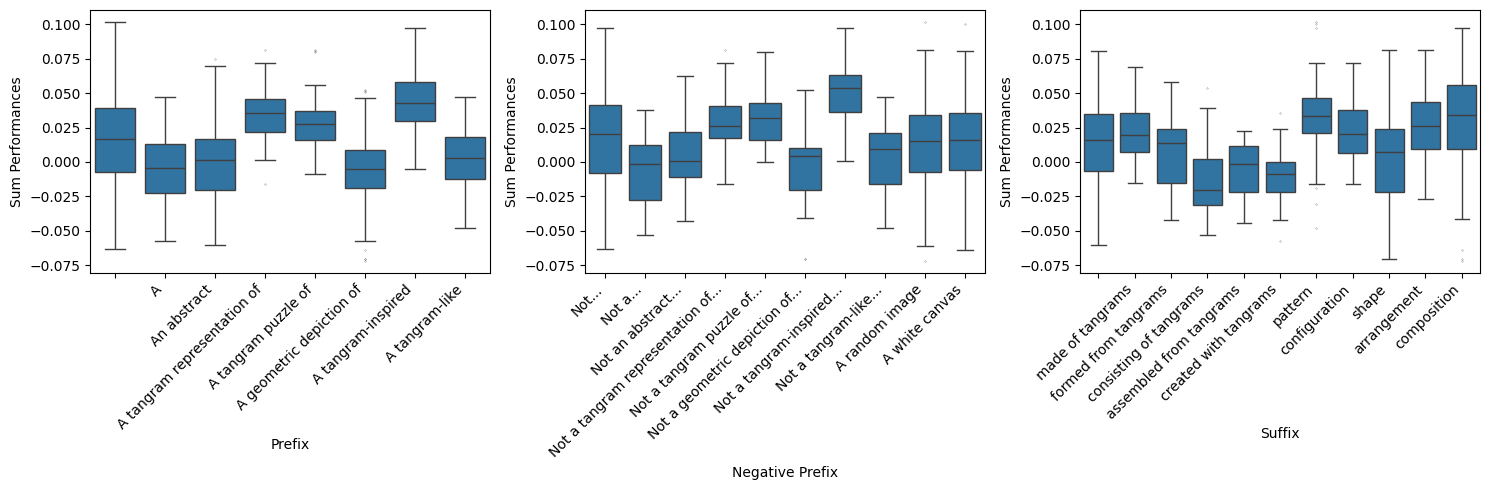

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for metric, ax in zip(["Prefix", "Negative Prefix", "Suffix"], axs):
    sns.boxplot(x=metric, y="Sum Performances", data=master_dataframe, fliersize=0.2, ax=ax)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

---

In [ ]:
# interact(lambda x="Alpha (Text)", y="Sum Performances": sns.boxplot(x=x, y=y, data=master_dataframe, ax=plt.subplots(1, 1, figsize=(15, 5))[1]), x=master_dataframe.columns, y=master_dataframe.columns)

In [ ]:
metric_performance = []
for k, v in metrics['normal'].items():
    metric_performance.append([*k, np.diff(v, axis=0).squeeze().mean(), np.diff(v, axis=1).squeeze().std()])
metric_performance = pd.DataFrame(metric_performance, columns=["Temperature", "Alpha (Text)", "Beta (Image)", "Mean Performance", "Std Performance"])

In [ ]:
# metric_performance = {}
# for k, v in metrics['normal'].items():
#     metric_performance[k] = np.diff(v, axis=0).squeeze().mean()

# from itertools import islice
# plt.figure(figsize=(15, 10))
# pd.DataFrame(dict(islice(metric_performance.items(), len(metric_performance)))).boxplot()

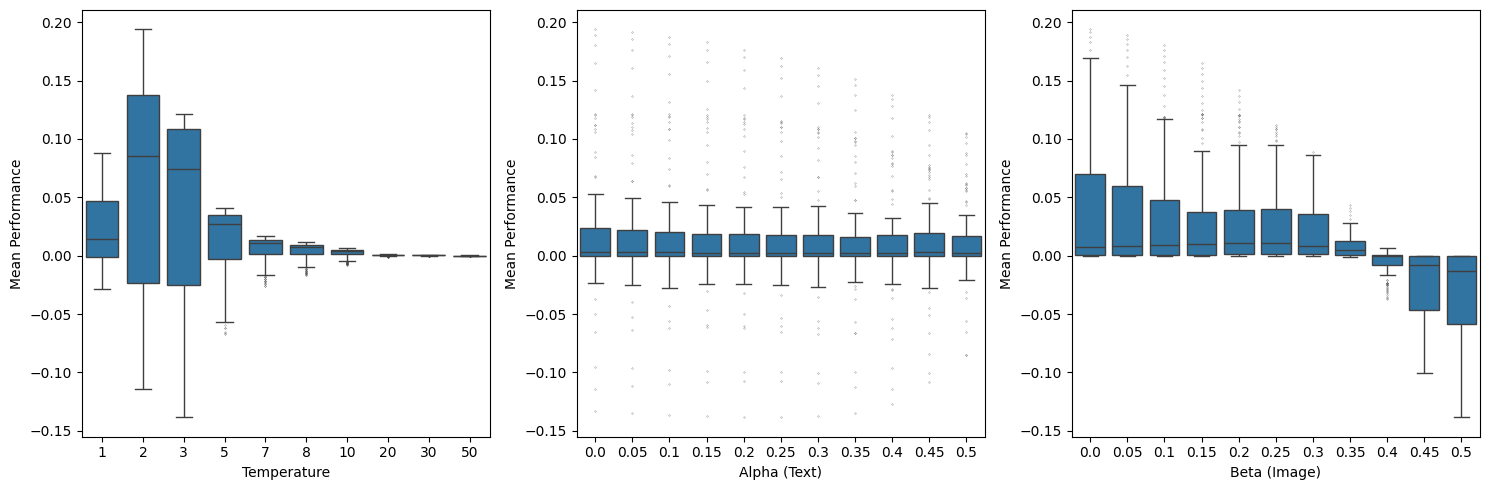

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for metric, ax in zip(["Temperature", "Alpha (Text)", "Beta (Image)"], axs):
    sns.boxplot(x=metric, y="Mean Performance", data=metric_performance, fliersize=0.2, ax=ax)
plt.tight_layout()